### Object Detection
Object detection identifies and localizes multiple objects in an image, unlike classification, which assigns a single label. It provides bounding boxes and labels for multiple objects in an image. This technique is widely used in various applications, including autonomous driving, surveillance, and medical image analysis.

### YOLO5
YOLO is a real-time object detection model that treats detection as a single regression problem, predicting bounding boxes and class probabilities in one forward pass. YOLOv5 is known for its speed and accuracy.

In this tutorial, we're going to use the YOLO5 model from ultralytics
``` python
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)`
```
In this tutorial, we're going to see how to use EigenCAM (one of the gradient-free methods) for YOLO5.

### Why EigenCAM?

EigenCAM is a technique that helps interpret CNN-based models by highlighting image regions most relevant to their decisions. Unlike Grad-CAM, which relies on backpropagation, EigenCAM uses a computationally efficient approach based on Singular Value Decomposition (SVD). It works by analyzing the final convolutional layer’s feature maps, decomposing them into principal components, and using the dominant eigenvectors to generate heatmaps.

This method provides a fast and lightweight way to visualize important image regions without requiring backpropagation, making it particularly useful for real-time applications.

This tutorial demonstrates how to implement EigenCAM on YOLOv5 to visualize influential image regions in object detection.

Thanks to: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

![image.png](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/yolo_eigencam.png)


### Install libraries
The 'pytorch_grad_cam' library implements various CAM techniques, including EigenCAM, to visualize important regions in deep learning models. You can install it using the following command:


In [ ]:
!pip install grad-cam

### Import libraries
Let's start with importing the necessary software libraries.

In [12]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

### Bounding Box Detection in YOLOv5
In object detection, the bounding box is represented by two points: the top-left corner (xmin, ymin) and the bottom-right corner (xmax, ymax).

The parse_detections function processes the raw detection results from YOLOv5, filters out low-confidence detections, and returns bounding box coordinates, associated class names, and colors for visualization.


**TODO:**
- Complete the function to find the min and max values and the name and category for each detection.
- Added them to the boxes list to be returned for further analysis or visualization.


In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [14]:
def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = detections["xmin"][i]

        ymin = detections["ymin"][i]
        xmax = detections["xmax"][i]
        ymax = detections["ymax"][i]
        name = detections["name"][i]
        category = detections["category"][i]
        color = COLORS[category]

        boxes.append([xmin, ymin, xmax, ymax])
        colors.append(color)
        names.append(name)
    return boxes, colors, names

### Visualizing Detections
The draw_detections function draws bounding boxes and labels for detected objects on an image, using the provided coordinates, colors, and names.

In [15]:
def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

### Loading & Running YOLOv5 for Object Detection
Let's load and preprocess the image, run YOLOv5 for object detection, and visualize the results with bounding boxes and labels.

**TODO:**
- Add the necessary image transformations to convert the image to a tensor using `transforms.ToTensor()`.
- Identify and specify the second-to-last layer of YOLOv5’s model that produces detection results, to extract feature maps for visualization with EigenCAM.  After printing the model and playing with it, this is in 'model.model.model.model[-2]'.

In [ ]:
img = np.array(Image.open(".\Image\puppies.jpg"))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = "FILL-IN"
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = "FILL-IN"

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

### Creating and Running the CAM Model
Now let's create our CAM model and run it on the image:

**TODO:**
   - **Initialize the EigenCAM object.** EigenCAM requires the model and the layer from which it will extract the 2D feature maps.**

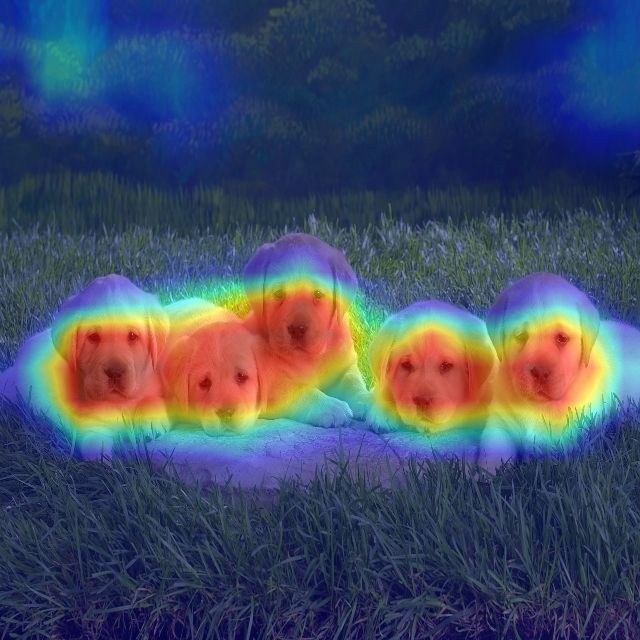

In [4]:
cam = "FILL-IN"
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

### Scaling CAM: Removing Heatmap Outside Bounding Boxes
This contains heatmaps mainly on the dogs, but not only.

Something we can do for object detection is remove heatmap data outside of the bounding boxes, and scale the heatmaps inside every bounding box.

**TODO:**

- **Complete the process of scaling the CAM in each bounding box region.** Inside the loop that iterates over `boxes`, ensure that `grayscale_cam` is properly scaled within each bounding box using the `scale_cam_image` function. This should apply only to the region inside each bounding box, leaving the areas outside the bounding box unaffected.

- **Renormalize the entire CAM.** After processing each bounding box, apply the `scale_cam_image` function to the entire `renormalized_cam` to ensure it is in the correct range and size for visualization.

- **Overlay the CAM onto the image.** Use `show_cam_on_image` to apply the renormalized CAM onto the input image (`image_float_np`). Make sure the heatmap is correctly shown in RGB forma

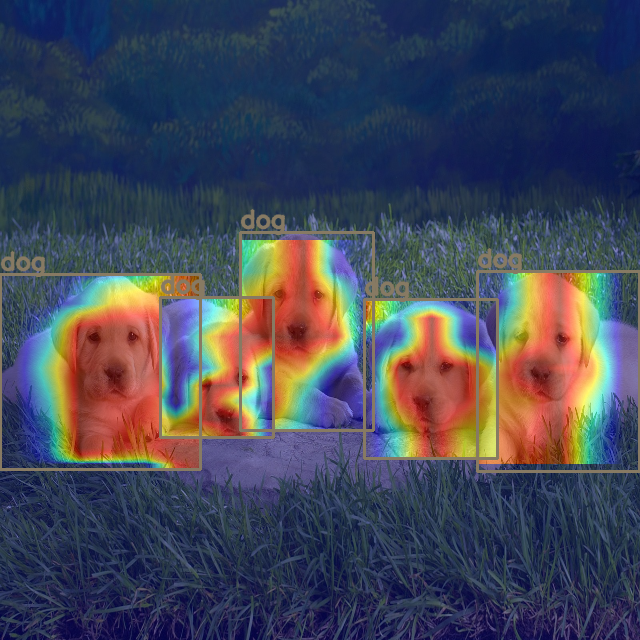

In [5]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = "FILL-IN" 
    renormalized_cam = "FILL_IN"
    eigencam_image_renormalized = "FILL_IN"
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)

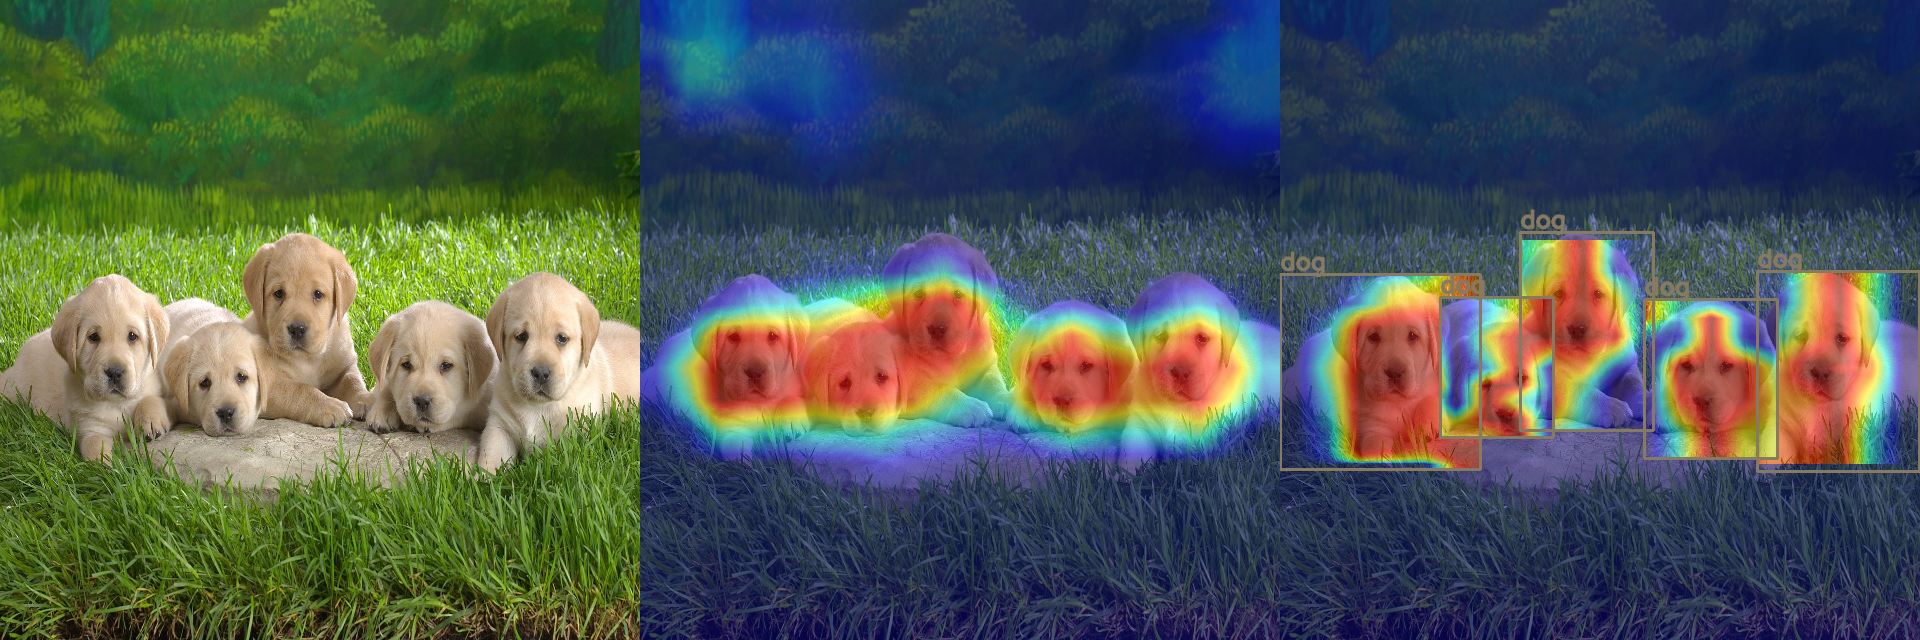

In [6]:
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))